In [ ]:
%%time
%cd '/content/drive/MyDrive/Colab Notebooks/OSAIL DL Task Submission'

/content/drive/MyDrive/Colab Notebooks/OSAIL DL Task Submission
CPU times: user 422 µs, sys: 2.31 ms, total: 2.74 ms
Wall time: 3.5 ms


In [ ]:
%%time
import tensorflow as tf
#print(tf.__version__)
from tensorflow import keras
import os
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

CPU times: user 2.37 s, sys: 639 ms, total: 3.01 s
Wall time: 3.65 s


In [ ]:
%%time
from keras.models import load_model
autoencoder = load_model('shima_inpaint_trail1.h5')
encoder = Model(autoencoder.input, autoencoder.layers[14].output)

CPU times: user 976 ms, sys: 612 ms, total: 1.59 s
Wall time: 4.45 s


In [ ]:
%%time
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 64)        36928     
                                                             

In [ ]:
%%time
%cd '/content/drive/MyDrive/Colab Notebooks/OSAIL_Data'

folders = os.listdir('Labeled')
print(folders)
image_data = []
labels = []

label_dict = {
             '0' : 0,
             '1' : 1,
             '2' : 2,
             '3' : 3,
             '4' : 4,
             }

for ix in folders:
    Pool1_path = os.path.join('Labeled',ix)
    print(Pool1_path)

for ix in folders:
    path = os.path.join('Labeled',ix)
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size=(112,112))
        img_array = image.img_to_array(img)
        #img_array = cv2.resize(img_array,(32,32))
        image_data.append(img_array)
        labels.append(label_dict[ix])
    print(len(image_data),len(labels))
combined = list(zip(image_data,labels))
random.shuffle(combined)
image_data[:],labels[:] = zip(*combined)

/content/drive/.shortcut-targets-by-id/1D6-ghKJJTIMr6KqHHkEb05lUW3b5wJpG/OSAIL_Data
['1', '3', '2', '4', '0']
Labeled/1
Labeled/3
Labeled/2
Labeled/4
Labeled/0
428 428
734 734
1349 1349
1420 1420
2352 2352
CPU times: user 3.24 s, sys: 579 ms, total: 3.82 s
Wall time: 38.6 s


In [ ]:
!pip install np_utils


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [ ]:
labels = np.array(labels)
image_data = np.array(image_data)

print(image_data.shape)
print(labels.shape)

(2352, 112, 112, 3)
(2352,)


In [ ]:
%%time
i = 0
yt =[]
yp =[]
import tensorflow
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
Adam = Adam(lr = 0.00003)
for j , (train_index, test_index) in enumerate(kf.split(image_data,labels)):
    print("******************************************************")
    print("************FOLD NUM", j)
    X_train, X_test = image_data[train_index], image_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    tensorflow.random.set_seed(42)

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    encoder.trainable = False
    input = keras.Input(shape=(112, 112, 3))
    x = encoder(input, training=False)

    gap = keras.layers.GlobalAveragePooling2D()(x)
    fc1 = keras.layers.Dense(200,activation = 'relu')(gap)
    dl =  keras.layers.Dropout(0.5)(fc1)
    fc2 =  keras.layers.Dense(5,activation = 'softmax')(dl)

    model_new = Model(input, fc2)
    model_new.summary()
    model_new.compile(Adam, loss='categorical_crossentropy', metrics=['accuracy'])   
    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    model_new.fit(X_train,y_train,shuffle = True,epochs = 20, validation_split = 0.3,callbacks=[es_callback])

    encoder.trainable = True
    model_new.compile(Adam, loss='categorical_crossentropy', metrics=['accuracy'])   
    model_new.fit(X_train,y_train,shuffle = True,epochs = 20, validation_split = 0.3,callbacks=[es_callback])

    pred = model_new.predict(X_test)

    pred[pred>.5] = 1
    pred[pred<.5] = 0
    
    y_test = np.argmax(y_test, axis=1)
    pred = np.argmax(pred, axis=1)
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, pred, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))
    yt.append(np.array(y_test).flatten())
    yp.append(np.array(pred).flatten())


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


******************************************************
************FOLD NUM 0
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 112, 112, 3)]     0         
                                                                 
 model (Functional)          (None, 7, 7, 512)         4712224   
                                                                 
 global_average_pooling2d_15  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 200)               102600    
                                                                 
 dropout_15 (Dropout)        (None, 200)               0         
                                                                 
 dense_31 (Dense)            (None, 5)        

**Metrics average on k-fold**

In [ ]:
yy =[]
pp = []
for i in range(len(yt)):
  for j in range(len(yt[i])):
    yy.append(yt[i][j])
    pp.append(yp[i][j])

In [ ]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, pred)))
print('Micro Precision: {:.2f}'.format(precision_score(y_test, pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))
print('\nClassification Report\n')
print(classification_report(yy, pp, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))



Accuracy: 0.92

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92


Classification Report

              precision    recall  f1-score   support

     Class 0       0.91      0.93      0.92       932
     Class 1       0.87      0.84      0.86       428
     Class 2       0.90      0.89      0.90       615
     Class 3       0.92      0.92      0.92       306
     Class 4       0.93      0.93      0.93        71

    accuracy                           0.90      2352
   macro avg       0.91      0.90      0.91      2352
weighted avg       0.90      0.90      0.90      2352



# **classification with naive classifier and PCA for dimension reduction**

In [ ]:
Pool1_path = '/content/drive/MyDrive/Colab Notebooks/OSAIL_Data/Labeled'


folders = os.listdir(Pool1_path)
print(folders)
image_data = []
labels = []

label_dict = {
             '0' : 0,
             '1' : 1,
             '2' : 2,
             '3' : 3,
             '4' : 4,
             }

for ix in folders:
    Pool1_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/OSAIL_Data/Labeled',ix)
    print(Pool1_path)
from keras.preprocessing import image
from PIL import Image


for ix in folders:
    path = os.path.join('/content/drive/MyDrive/Colab Notebooks/OSAIL_Data/Labeled',ix)
    for im in os.listdir(path):
        img = Image.open(os.path.join(path,im))
        img_array = image.img_to_array(img)
        #img_array = cv2.resize(img_array,(32,32))
        image_data.append(img_array)
        labels.append(label_dict[ix])
    print(len(image_data),len(labels))
combined = list(zip(image_data,labels))
np.random.shuffle(combined)
image_data[:],labels[:] = zip(*combined)
labels = np.array(labels)
image_data = np.array(image_data)
image_data = np.reshape(image_data,(2352,224,224))

#,target_size=(112,112)


t = []

for i in range(len(image_data)):
    t.append(image_data[i].ravel())

whole_data = np.array(t)


sc = StandardScaler()
pca = PCA(n_components=100)

tt = sc.fit_transform(whole_data)

whole_images_pca = pca.fit_transform(tt)
    
i = 0
yt2 =[]
yp2 =[]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

acc = []
model = GaussianNB()

for j , (train_index, test_index) in enumerate(kf.split(whole_images_pca,labels)):
    print("******************************************************")
    print("************FOLD NUM", j)
    X_train, X_test = whole_images_pca[train_index], whole_images_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #Create a Gaussian Classifier

  # Train the model using the training sets
    model.fit(X_train,y_train)
    #Predict Output
    pred= model.predict(X_test) 
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, pred, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))
    yt2.append(np.array(y_test).flatten())
    yp2.append(np.array(pred).flatten())





['1', '3', '2', '4', '0']
/content/drive/MyDrive/Colab Notebooks/OSAIL_Data/Labeled/1
/content/drive/MyDrive/Colab Notebooks/OSAIL_Data/Labeled/3
/content/drive/MyDrive/Colab Notebooks/OSAIL_Data/Labeled/2
/content/drive/MyDrive/Colab Notebooks/OSAIL_Data/Labeled/4
/content/drive/MyDrive/Colab Notebooks/OSAIL_Data/Labeled/0
428 428
734 734
1349 1349
1420 1420
2352 2352
******************************************************
************FOLD NUM 0

Accuracy: 0.39

Micro Precision: 0.39
Micro Recall: 0.39
Micro F1-score: 0.39

Macro Precision: 0.33
Macro Recall: 0.32
Macro F1-score: 0.32

Weighted Precision: 0.36
Weighted Recall: 0.39
Weighted F1-score: 0.37

Classification Report

              precision    recall  f1-score   support

     Class 0       0.46      0.64      0.54       186
     Class 1       0.19      0.13      0.15        86
     Class 2       0.36      0.31      0.33       123
     Class 3       0.34      0.18      0.23        62
     Class 4       0.29      0.36      0.

**Metrics average on k-fold**

In [ ]:
%%time
yy2 =[]
pp2 = []
for i in range(len(yt2)):
  for j in range(len(yt2[i])):
    yy2.append(yt2[i][j])
    pp2.append(yp2[i][j])


print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, pred)))
print('Micro Precision: {:.2f}'.format(precision_score(y_test, pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))
print('\nClassification Report\n')
print(classification_report(yy2, pp2, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))


Accuracy: 0.42

Micro Precision: 0.42
Micro Recall: 0.42
Micro F1-score: 0.42


Classification Report

              precision    recall  f1-score   support

     Class 0       0.45      0.67      0.54       932
     Class 1       0.24      0.11      0.15       428
     Class 2       0.34      0.31      0.33       615
     Class 3       0.34      0.17      0.22       306
     Class 4       0.31      0.31      0.31        71

    accuracy                           0.40      2352
   macro avg       0.34      0.31      0.31      2352
weighted avg       0.37      0.40      0.36      2352

CPU times: user 13.9 ms, sys: 3.19 ms, total: 17.1 ms
Wall time: 15.9 ms


**Box plot to compare the results of two classifier in 5 folds**

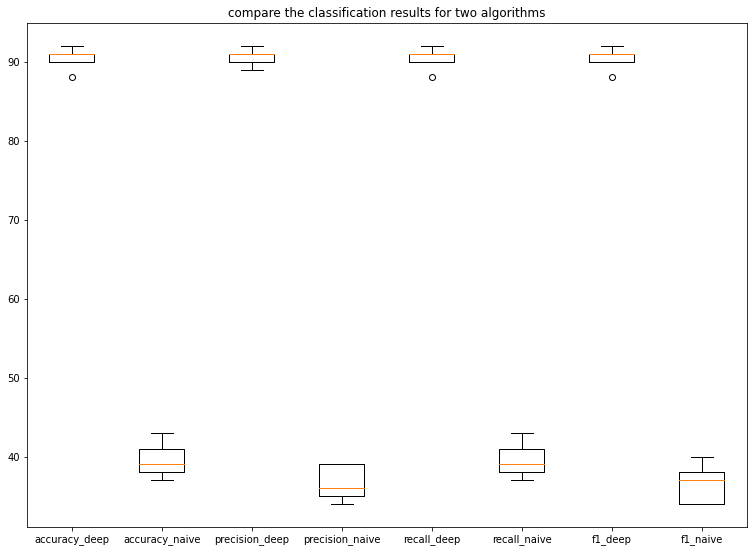

In [ ]:
acc_deep = [88,91,91,90,92]
acc_naive = [39,43,41,38,37]
pre_deep = [89,91,91,90,92]
pre_naive = [36,39,39,34,35]
recall_deep = [88,91,91,90,92]
recall_naive = [39,43,41,38,37]
f1_deep = [88,91,91,90,92]
f1_naive = [37,40,38,34,34]
data = [acc_deep, acc_naive ,pre_deep,pre_naive,recall_deep,recall_naive,f1_deep,f1_naive]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
plt.title("compare the classification results for two algorithms")

# Creating plot
bp = ax.boxplot(data)
ax.set_xticklabels(['accuracy_deep', 'accuracy_naive','precision_deep','precision_naive','recall_deep','recall_naive','f1_deep','f1_naive'])
# show plot
plt.show()